Citation Request:
   This breast cancer domain was obtained from the University Medical Centre,
   Institute of Oncology, Ljubljana, Yugoslavia.  Thanks go to M. Zwitter and 
   M. Soklic for providing the data.  Please include this citation if you plan
   to use this database.

1. Title: Breast cancer data (Michalski has used this)

2. Sources: 
   -- Matjaz Zwitter & Milan Soklic (physicians)
      Institute of Oncology 
      University Medical Center
      Ljubljana, Yugoslavia
   -- Donors: Ming Tan and Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
   -- Date: 11 July 1988

3. Past Usage: (Several: here are some)
     -- Michalski,R.S., Mozetic,I., Hong,J., & Lavrac,N. (1986). The 
        Multi-Purpose Incremental Learning System AQ15 and its Testing 
        Application to Three Medical Domains.  In Proceedings of the 
        Fifth National Conference on Artificial Intelligence, 1041-1045,
        Philadelphia, PA: Morgan Kaufmann.
        -- accuracy range: 66%-72%
     -

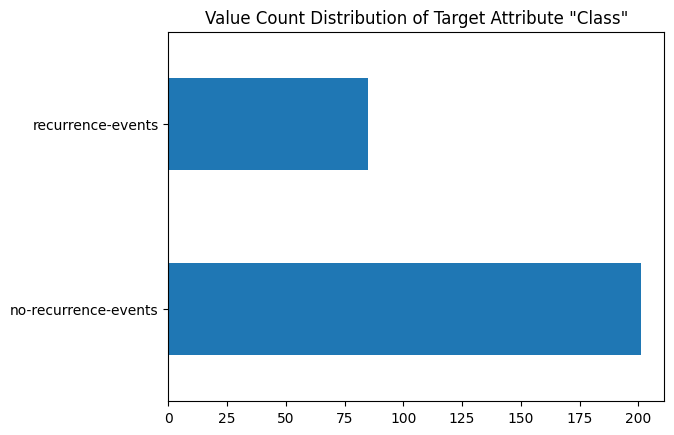

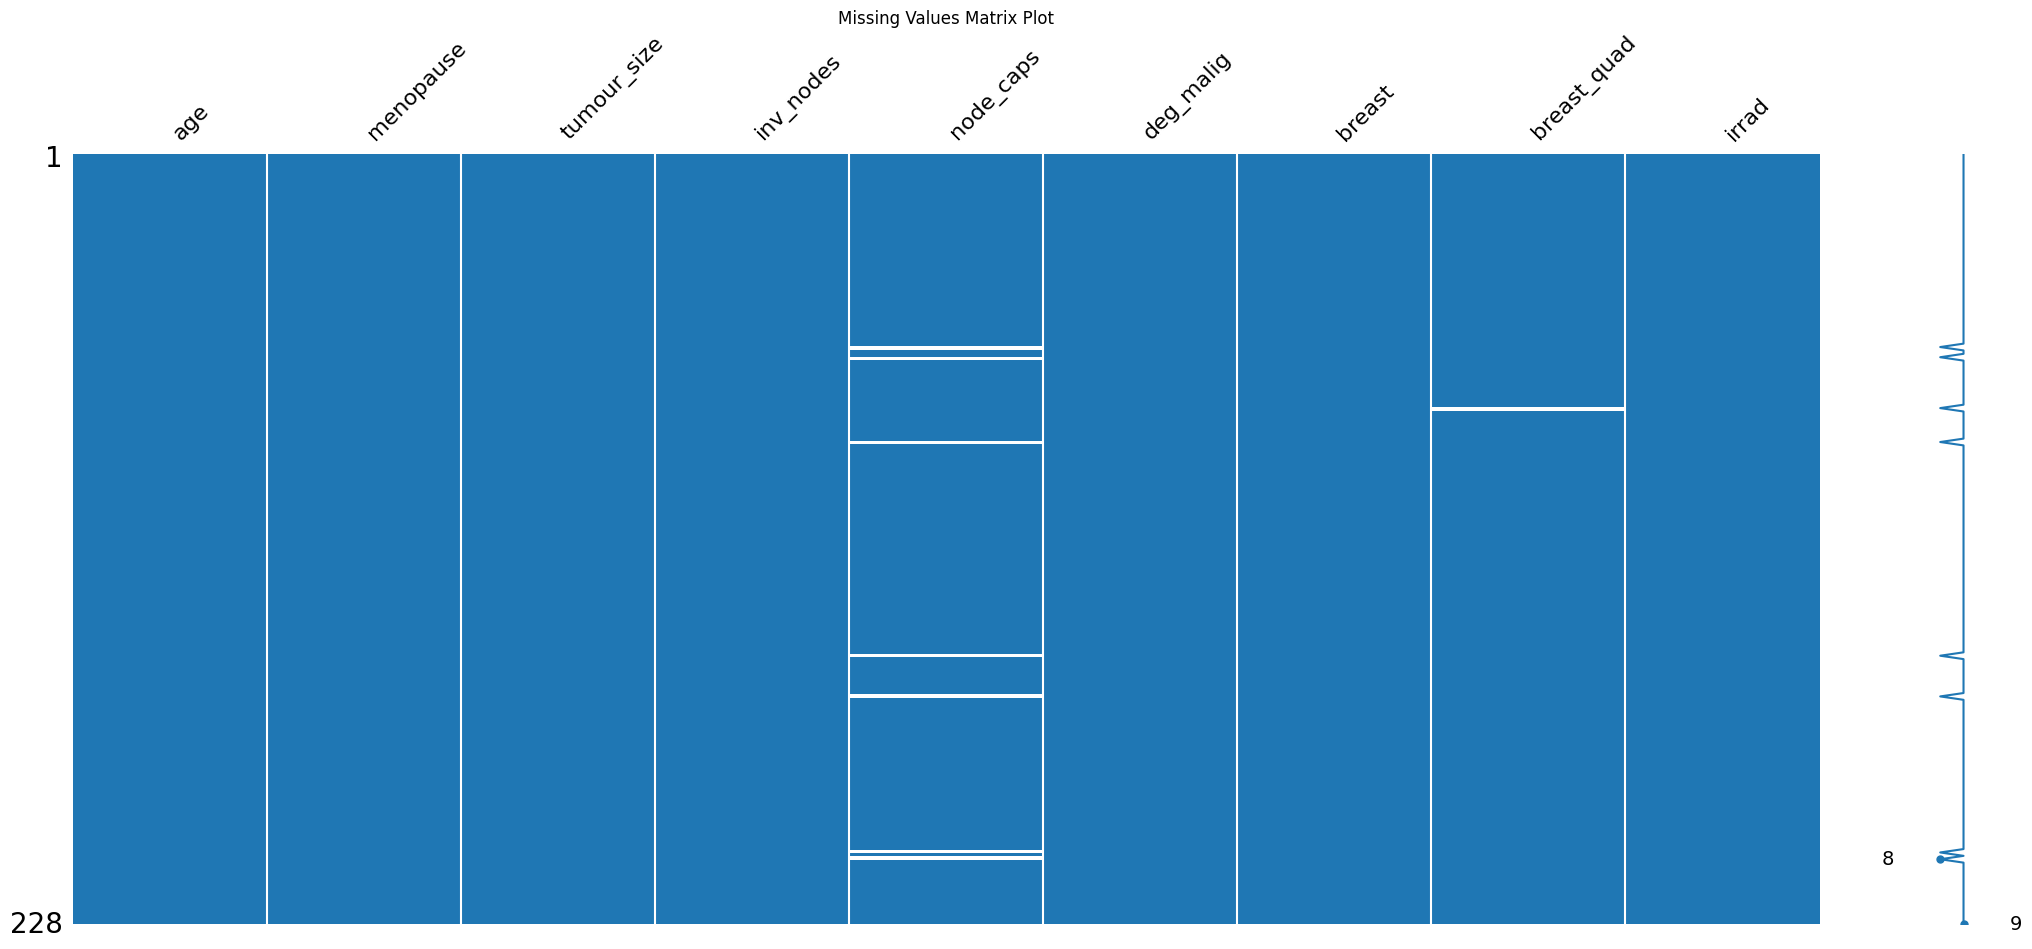

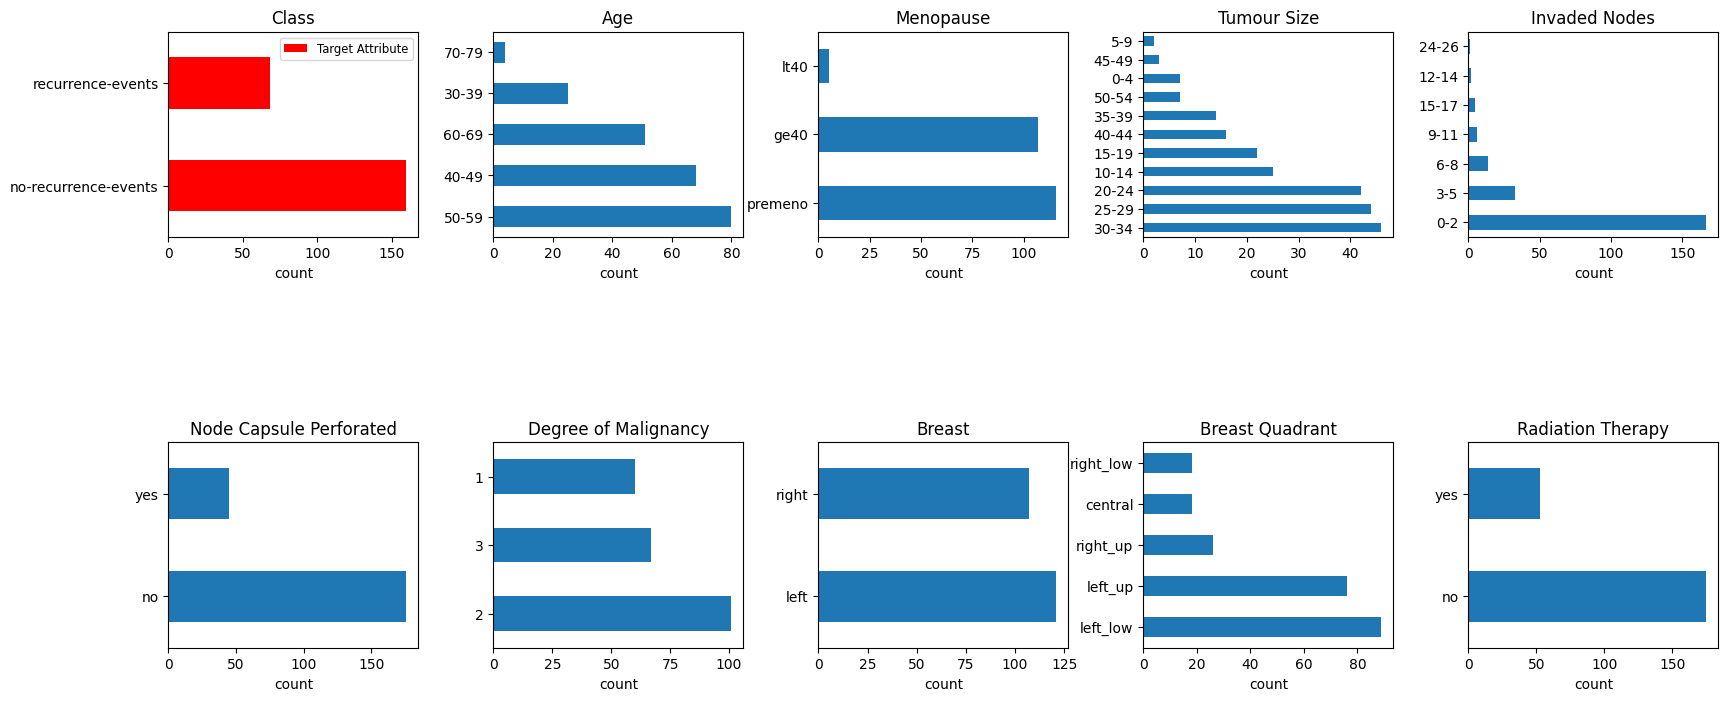

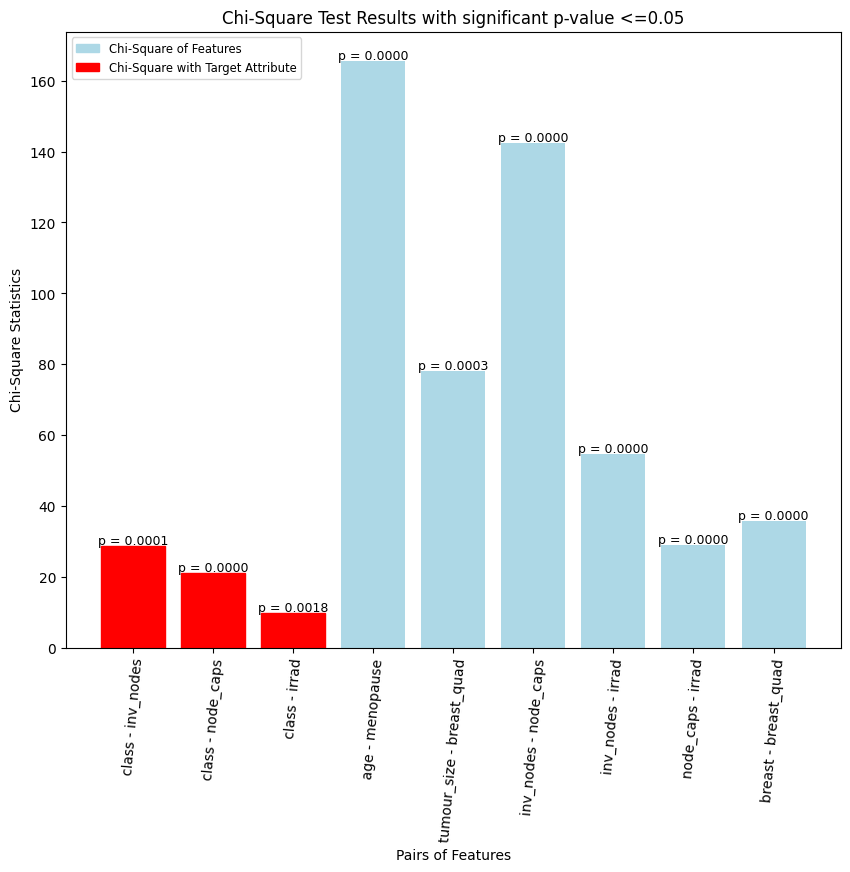

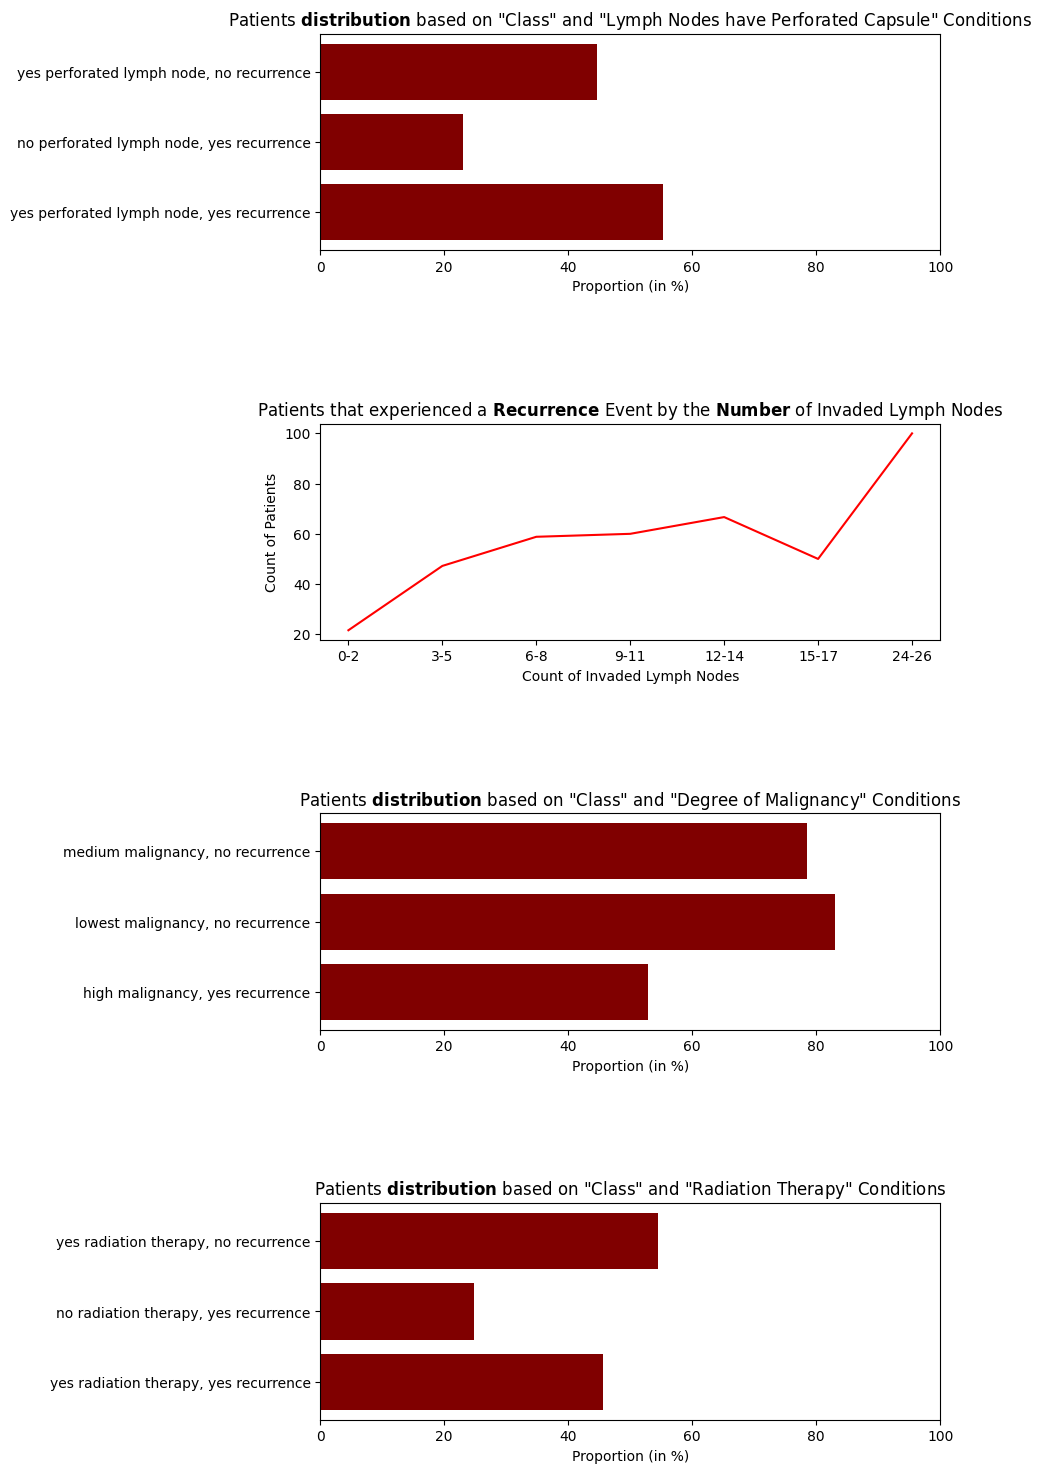

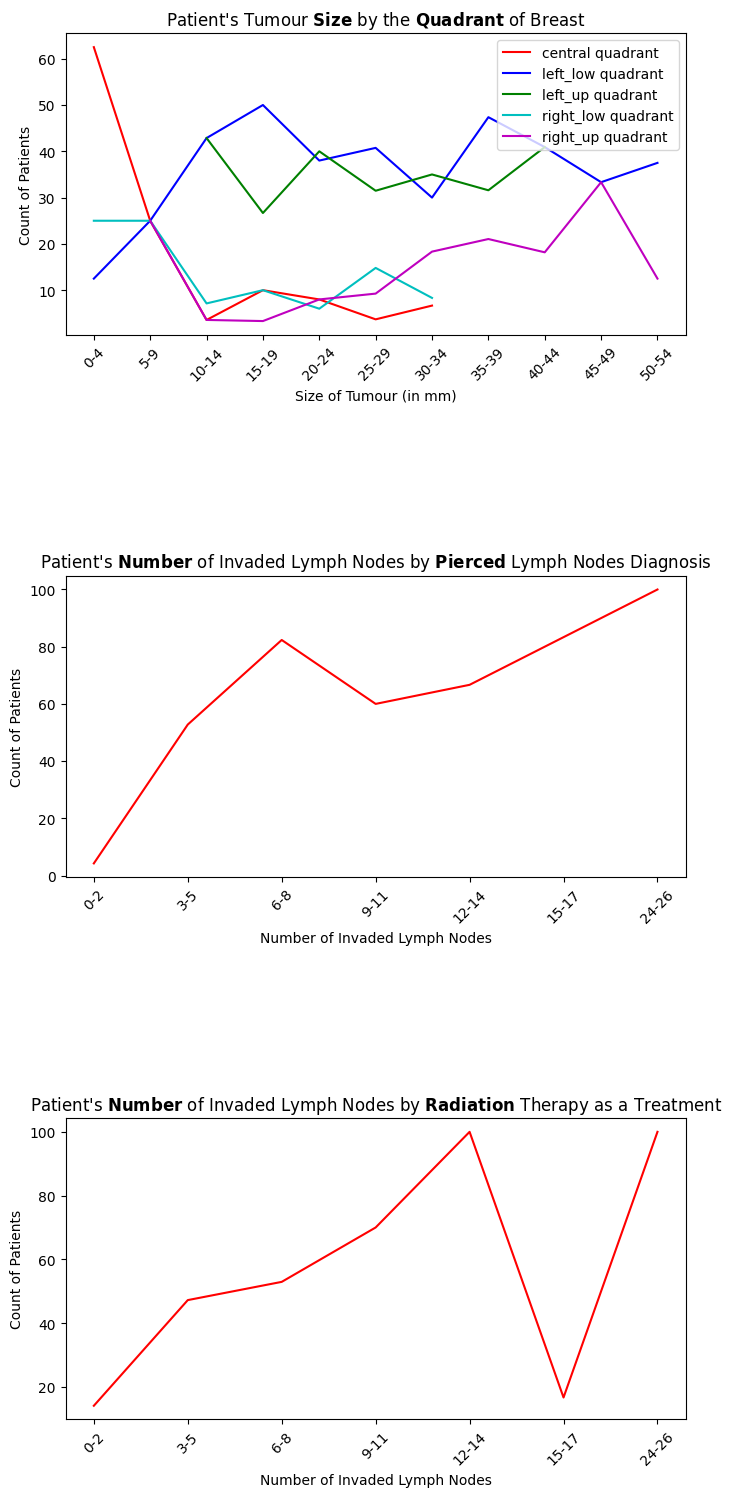

In [321]:
%run eda_prediction_recurrence_breast_cancer.ipynb

In [322]:
# import the necessary libraries
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


from IPython.display import display


- nominal features
    - menopause
    - node_caps
    - breast
    - breast_quad
    - irrad
    - class (*target feature*)
- ordinal features
    - age
    - tumour_size
    - inv_nodes
- numerical feature
    - deg_malig

#### Compute Feature Importance

Before identifying the most promising transformations I can make on features I want to have a look at feature importance

In [323]:
columns_to_keep = ['inv_nodes', 'node_caps', 'irrad', 'breast_quad', 'deg_malig', 'tumour_size']
X_train = X_train[columns_to_keep]

In [324]:
# Encode nominal features using one-hot encoding with drop_first=True
X_train_nominal = pd.get_dummies(X_train[['node_caps','breast_quad', 'irrad']])


# perform label encoding for ordinal features
label_encoder = preprocessing.LabelEncoder()
X_train_ordinal = X_train[['inv_nodes', 'tumour_size']]
for col in X_train_ordinal.columns:
    X_train_ordinal[col] = label_encoder.fit_transform(X_train_ordinal[col])


X_train_numerical = X_train[['deg_malig']]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [325]:
X_train_encoded = pd.concat([X_train_nominal, X_train_ordinal, X_train_numerical], axis=1)

In [326]:
X_train_encoded.head()

,node_caps_no,node_caps_yes,breast_quad_central,breast_quad_left_low,breast_quad_left_up,breast_quad_right_low,breast_quad_right_up,irrad_no,irrad_yes,inv_nodes,tumour_size,deg_malig
215,1,0,0,0,1,0,0,1,0,0,3,2
41,1,0,0,1,0,0,0,1,0,0,4,2
24,1,0,0,0,1,0,0,1,0,0,6,2
161,0,1,0,1,0,0,0,1,0,4,5,2
144,0,1,1,0,0,0,0,1,0,5,8,3


In [327]:
y_train_encoded = y_train.replace(['no-recurrence-events', 'recurrence-events'], [0,1])

In [328]:
# create a validation set to train and evaluate the model
X_train_eval, X_eval, y_train_eval, y_eval = train_test_split(X_train_encoded, y_train_encoded, test_size=0.2, stratify=y_train_encoded, random_state=42)

In [329]:
def normal_pred(model, X_train, y_train, X_test, y_test):
    #normal model
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(model, 'Normal')
    print(report)
    

def resampling(model, X_train, y_train, X_test, y_test):
    #resampling model
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_eval_resampled, y_eval_resampled = ros.fit_resample(X_test, y_test)
    model = model 
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_eval_resampled)
    report = classification_report(y_eval_resampled, y_pred)
    print(model, 'Resampled')
    print(report)
    

def smote(model, X_train, y_train, X_test, y_test):
    #smote sampling model
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train) 
    X_eval_resampled, y_eval_resampled = smote.fit_resample(X_test, y_test)
    model = model 
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_eval_resampled)
    report = classification_report(y_eval_resampled, y_pred)
    print(model, 'SMOTE Sampling')
    print(report)


In [330]:
print('BEFORE FEATURE SELECTION')

models = [RandomForestClassifier(),LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=5), SVC(kernel='linear', probability=True)]

for model in models:
    normal_pred(model, X_train_eval, y_train_eval, X_eval, y_eval)
    resampling(model, X_train_eval, y_train_eval, X_eval, y_eval)
    smote(model, X_train_eval, y_train_eval, X_eval, y_eval)

BEFORE FEATURE SELECTION
RandomForestClassifier() Normal
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        32
           1       0.64      0.50      0.56        14

    accuracy                           0.76        46
   macro avg       0.72      0.69      0.70        46
weighted avg       0.75      0.76      0.75        46

RandomForestClassifier() Resampled
              precision    recall  f1-score   support

           0       0.69      0.78      0.74        32
           1       0.75      0.66      0.70        32

    accuracy                           0.72        64
   macro avg       0.72      0.72      0.72        64
weighted avg       0.72      0.72      0.72        64

RandomForestClassifier() SMOTE Sampling
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        32
           1       0.81      0.81      0.81        32

    accuracy                           0.81       

In [331]:
"""
clf = RandomForestClassifier()
clf.fit(X_train_encoded,y_train_encoded)
clf_importances = clf.feature_importances_

lr = LogisticRegression()
lr.fit(X_train_encoded, y_train_encoded)
lr_coefs = np.abs(lr.coef_[0])
lr_importances = lr_coefs / lr_coefs.sum()


fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'height_ratios': [10]})
fig.set_size_inches(12,6)

ax1.bar(X_train_encoded.columns, clf.feature_importances_)
ax1.set_xticks(range(len(X_train_encoded.columns)))
ax1.set_xticklabels(X_train_encoded.columns, rotation=85)
ax1.set_title('Random Forest Feature Importances')


ax2.bar(X_train_encoded.columns, lr_importances)
ax2.set_xticks(range(len(X_train_encoded.columns)))
ax2.set_xticklabels(X_train_encoded.columns, rotation=85)
ax2.set_title('Logistic Regression Feature Importances')

plt.show()
"""

"\nclf = RandomForestClassifier()\nclf.fit(X_train_encoded,y_train_encoded)\nclf_importances = clf.feature_importances_\n\nlr = LogisticRegression()\nlr.fit(X_train_encoded, y_train_encoded)\nlr_coefs = np.abs(lr.coef_[0])\nlr_importances = lr_coefs / lr_coefs.sum()\n\n\nfig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'height_ratios': [10]})\nfig.set_size_inches(12,6)\n\nax1.bar(X_train_encoded.columns, clf.feature_importances_)\nax1.set_xticks(range(len(X_train_encoded.columns)))\nax1.set_xticklabels(X_train_encoded.columns, rotation=85)\nax1.set_title('Random Forest Feature Importances')\n\n\nax2.bar(X_train_encoded.columns, lr_importances)\nax2.set_xticks(range(len(X_train_encoded.columns)))\nax2.set_xticklabels(X_train_encoded.columns, rotation=85)\nax2.set_title('Logistic Regression Feature Importances')\n\nplt.show()\n"

In [332]:
"""
top_features_forest = X_train_encoded.columns[np.argsort(clf.feature_importances_)[::-1][:6]]
top_features_forest
"""

'\ntop_features_forest = X_train_encoded.columns[np.argsort(clf.feature_importances_)[::-1][:6]]\ntop_features_forest\n'

In [333]:
"""
top_features_logistic = X_train_encoded.columns[np.argsort(lr_importances)[::-1][:6]]
top_features_logistic
"""

'\ntop_features_logistic = X_train_encoded.columns[np.argsort(lr_importances)[::-1][:6]]\ntop_features_logistic\n'

In [334]:
"""
X_train_encoded = X_train_encoded[top_features_logistic]

# create a validation set to train and evaluate the model
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train_encoded, y_train_encoded, test_size=0.2, stratify=y_train_encoded, random_state=42)
"""

'\nX_train_encoded = X_train_encoded[top_features_logistic]\n\n# create a validation set to train and evaluate the model\nX_train_val, X_val, y_train_val, y_val = train_test_split(X_train_encoded, y_train_encoded, test_size=0.2, stratify=y_train_encoded, random_state=42)\n'

In [335]:
"""
print('AFTER FEATURE SELECTION')
models = [RandomForestClassifier(),LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=5), SVC(kernel='linear', probability=True)]

for model in models:
    normal_pred(model, X_train_val, y_train_val, X_val, y_val)
    resampling(model, X_train_val, y_train_val, X_val, y_val)
    smote(model, X_train_val, y_train_val, X_val, y_val)
"""

"\nprint('AFTER FEATURE SELECTION')\nmodels = [RandomForestClassifier(),LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=5), SVC(kernel='linear', probability=True)]\n\nfor model in models:\n    normal_pred(model, X_train_val, y_train_val, X_val, y_val)\n    resampling(model, X_train_val, y_train_val, X_val, y_val)\n    smote(model, X_train_val, y_train_val, X_val, y_val)\n"

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        32
           1       0.81      0.81      0.81        32

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted avg       0.81      0.81      0.81        64



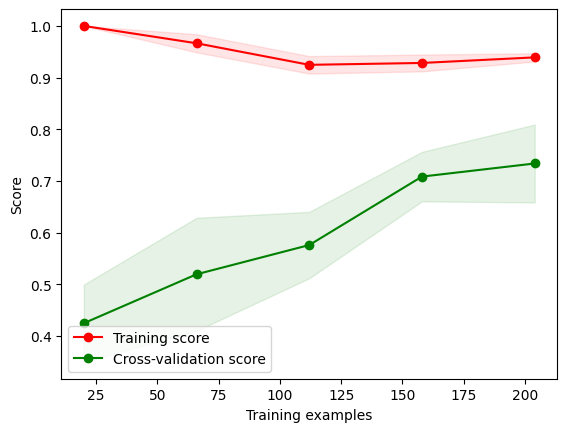

In [336]:
model = RandomForestClassifier()

# performing resampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_eval, y_train_eval)
X_eval_resampled, y_eval_resampled = smote.fit_resample(X_eval, y_eval)
model = model 
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_eval_resampled)
report = classification_report(y_eval_resampled, y_pred)
y_score = model.predict_proba(X_eval_resampled)[:, 1]
print(report)


# Learning Curve

train_sizes, train_scores, valid_scores = learning_curve(model, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

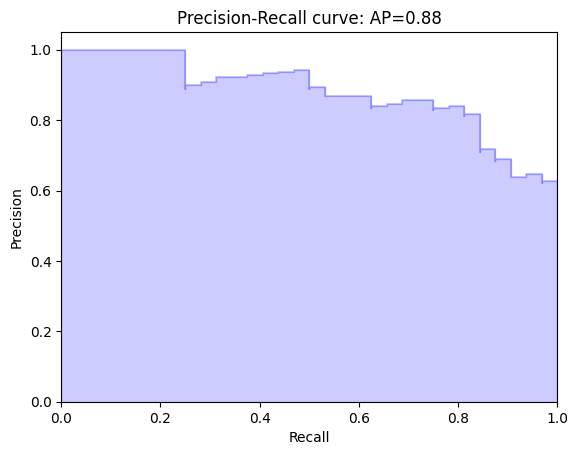

In [337]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_eval_resampled, y_score)
average_precision = average_precision_score(y_eval_resampled, y_score)

# plot the precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

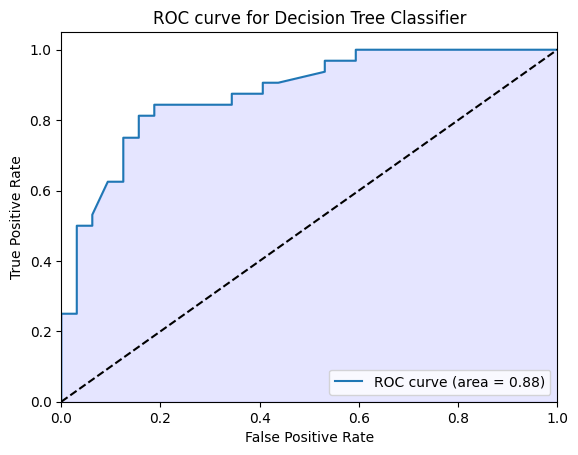

In [338]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_eval_resampled, y_score)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.fill_between(fpr, tpr, 0, color='blue', alpha=0.1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()


In [339]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_eval_resampled, y_eval_resampled, n_repeats=10, random_state=0)
importance_scores = result.importances_mean
sorted_idx = importance_scores.argsort()
for i in sorted_idx:
    print(f"{X_eval_resampled.columns[i]}: {importance_scores[i]}")

inv_nodes: -0.00625
node_caps_yes: 0.003125
breast_quad_central: 0.015625
irrad_yes: 0.015625
breast_quad_right_low: 0.0171875
breast_quad_right_up: 0.0171875
deg_malig: 0.0515625
breast_quad_left_low: 0.0765625
breast_quad_left_up: 0.0828125
tumour_size: 0.096875
node_caps_no: 0.10625
irrad_no: 0.109375


Permutation explainer: 65it [00:22,  1.58it/s]                        


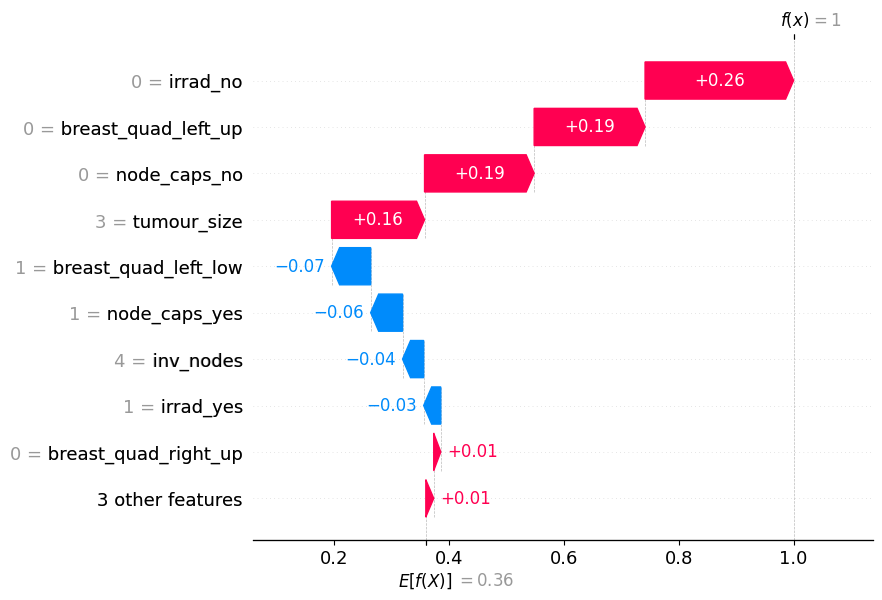

In [340]:
import shap

explainer = shap.Explainer(model.predict, X_train_resampled)
shap_values = explainer(X_eval_resampled)

# Plot the SHAP values for a single prediction
shap.plots.waterfall(shap_values[0])

### PERFORM CROSS-VALIDATION USING GREAT SEARCHCV TO TUNE THE MODEL

In [341]:
model = RandomForestClassifier()

# define the hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', {0:1, 1:5}]
}

# define the cross-validation scheme
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# define the scoring metric
scorer = make_scorer(f1_score)

# perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scorer, n_jobs=-1)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_eval, y_train_eval)


grid_search.fit(X_train_resampled, y_train_resampled)
best_params = grid_search.best_params_
# print the best hyperparameters and F1 score
print("Best hyperparameters:", best_params)
print("Best F1 score:", round(grid_search.best_score_, 2))


Best hyperparameters: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 score: 0.77


##### YOU HAVE TO DO THE Test Pipeline

In [342]:
X_test = X_test[columns_to_keep]                                                                                                            
# Encode nominal features using one-hot encoding with drop_first=True
X_test_nominal = pd.get_dummies(X_test[['node_caps','breast_quad', 'irrad']])


# perform label encoding for ordinal features
label_encoder = preprocessing.LabelEncoder()
X_test_ordinal = X_test[['inv_nodes', 'tumour_size']]
for col in X_test_ordinal.columns:
    X_test_ordinal[col] = label_encoder.fit_transform(X_test_ordinal[col])


X_test_numerical = X_test[['deg_malig']]                                                                                                
X_test_encoded = pd.concat([X_test_nominal, X_test_ordinal, X_test_numerical], axis=1) # NEW FEATURE       
#X_test_encoded['agg'] = X_test_encoded['tumour_size'] * X_test_encoded['node_caps_yes'] * X_test_encoded['inv_nodes']
y_test_encoded = y_test.replace(['no-recurrence-events', 'recurrence-events'], [0,1])                              

#X_test_encoded = X_test_encoded[top_features_logistic]                                                                     

smote = SMOTE(random_state=42)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test_encoded, y_test_encoded)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [343]:
model = RandomForestClassifier(**best_params)


model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test_resampled)


target_names = ['0: no-recurrence-events', '1: recurrence-events']
report = classification_report(y_test_resampled, y_pred, target_names=target_names)
print('Model Performance on Unseen Data')
print(report)

Model Performance on Unseen Data
                         precision    recall  f1-score   support

0: no-recurrence-events       0.61      0.83      0.70        41
   1: recurrence-events       0.73      0.46      0.57        41

               accuracy                           0.65        82
              macro avg       0.67      0.65      0.63        82
           weighted avg       0.67      0.65      0.63        82

